In [1]:
import pandas as pd
import numpy as np

In [2]:
import pickle

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [4]:
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score,  recall_score, precision_score
from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)


In [5]:
from my_metr import plot_roc_curve

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
biz_df = pd.read_csv('biz_cluster10.csv')

In [9]:
biz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57173 entries, 0 to 57172
Data columns (total 16 columns):
Unnamed: 0                57173 non-null int64
business_id               57173 non-null object
RestaurantsPriceRange2    51111 non-null float64
stars                     57173 non-null float64
review_count              57173 non-null int64
categories                57173 non-null object
cl_0                      3408 non-null float64
cl_1                      39190 non-null float64
cl_2                      1 non-null float64
cl_3                      10110 non-null float64
cl_4                      1618 non-null float64
cl_5                      16383 non-null float64
cl_6                      23148 non-null float64
cl_7                      0 non-null float64
cl_8                      3980 non-null float64
cl_9                      3619 non-null float64
dtypes: float64(12), int64(2), object(2)
memory usage: 7.0+ MB


In [8]:
biz_df.head(3)

,Unnamed: 0,business_id,RestaurantsPriceRange2,stars,review_count,categories,cl_0,cl_1,cl_2,cl_3,...,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17
0,0,--9e1ONYQuAa-CB_Rrw7Tw,4.0,4.0,1546,"Steakhouses, Restaurants, Cajun/Creole",0.0,1.0,2.0,NaN,...,8.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,16.0,17.0
1,1,-VAsjhmAbKF3Pb_-8rh3xg,1.0,2.0,10,"Fast Food, Burgers, Restaurants",NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-cxD1NimFldATDUsN-oa3A,2.0,2.0,23,"Mexican, Restaurants",NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cleaning

In [10]:
biz_cl = biz_df.copy()
for i in range (10):
    col_new = 'cl_t'+str(i)
    col_old = 'cl_'+str(i)
    biz_cl[col_new] = ~pd.isnull(biz_df[col_old])
    biz_cl.drop(col_old, axis =1, inplace= True)


In [11]:
biz_cl.shape

(57173, 16)

In [12]:
biz_cl['how_many_cl'] = 0
for i in range (10):
    col_new = 'cl_t'+str(i)
    biz_cl['how_many_cl'] += biz_cl[col_new]



In [13]:
len(biz_cl[biz_cl['how_many_cl']>4])

3104

In [14]:
len(biz_cl[biz_cl['how_many_cl']>5])

713

In [19]:
len(biz_cl)

57173

In [15]:
def expand_features(X, col='features', inplace=False, sep=None):
    X = X.copy() if not inplace else X
    if sep==None:
        for i in range(len(X[col].iloc[0])):
             X['feature_' + str(i)] = X[col].apply(lambda x: x[i])
    else:
        lbls = np.unique(sep.join(X[col].unique()).split(sep))
        lbls = np.unique([l.strip() for l in lbls])
        for lbl in lbls:
            X[lbl] = X[col].apply(lambda x: lbl in x)
        X.drop(col, axis=1, inplace=True)
    return X

In [16]:
biz_cl1 = expand_features(biz_cl, col='categories', sep =',')

In [17]:
biz_cl1['num_of_categ'] = biz_df.categories.map(lambda x: len(x.split(',')))

In [18]:
biz_cl1.shape, biz_cl1.columns[:27]

((57173, 724),
 Index(['Unnamed: 0', 'business_id', 'RestaurantsPriceRange2', 'stars',
        'review_count', 'cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4', 'cl_t5',
        'cl_t6', 'cl_t7', 'cl_t8', 'cl_t9', 'how_many_cl', '& Probates',
        'Acai Bowls', 'Accessories', 'Accountants', 'Active Life',
        'Acupuncture', 'Adult Education', 'Adult Entertainment', 'Advertising',
        'Afghan', 'African'],
       dtype='object'))

In [19]:
colClust =['cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4', 'cl_t5',
        'cl_t6', 'cl_t7', 'cl_t8', 'cl_t9']

In [20]:
biz_cl1[colClust].corr()

,cl_t0,cl_t1,cl_t2,cl_t3,cl_t4,cl_t5,cl_t6,cl_t7,cl_t8,cl_t9
cl_t0,1.000000,0.070472,-0.001053,0.031631,-0.039402,-0.037345,0.061130,NaN,0.017347,-0.029345
cl_t1,0.070472,1.000000,0.002833,0.249689,0.071763,0.282010,0.367572,NaN,0.149177,0.120866
cl_t2,-0.001053,0.002833,1.000000,0.009023,-0.000714,-0.002651,0.005070,NaN,-0.001144,-0.001087
cl_t3,0.031631,0.249689,0.009023,1.000000,0.072953,0.323030,0.383915,NaN,0.325909,0.168512
cl_t4,-0.039402,0.071763,-0.000714,0.072953,1.000000,0.036941,0.076691,NaN,0.044912,-0.025738
cl_t5,-0.037345,0.282010,-0.002651,0.323030,0.036941,1.000000,0.327355,NaN,0.263347,0.085782
cl_t6,0.061130,0.367572,0.005070,0.383915,0.076691,0.327355,1.000000,NaN,0.241464,0.161955
cl_t7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cl_t8,0.017347,0.149177,-0.001144,0.325909,0.044912,0.263347,0.241464,NaN,1.000000,0.108121
cl_t9,-0.029345,0.120866,-0.001087,0.168512,-0.025738,0.085782,0.161955,NaN,0.108121,1.000000


In [21]:
mmm = biz_cl1[biz_cl1.columns[16:]].mean(axis = 0)

In [22]:
mmm.describe()

count    708.000000
mean       0.011466
std        0.154915
min        0.000017
25%        0.000017
50%        0.000087
75%        0.000896
max        3.972067
dtype: float64

In [23]:
ll = mmm[mmm<0.0005]

In [22]:
ll.to_csv('d.txt')

In [25]:
len(ll)

499

In [31]:
l2 = mmm[mmm>=0.0005]
len(l2)

209

In [26]:
fe = pd.read_csv('model_cat.csv')

In [30]:
len(fe)

209

In [44]:
#l2.to_csv('model_cat.csv', header= True)


In [32]:
biz_cl2 = biz_cl1.drop(ll.index, axis = 1)

In [33]:
biz_cl2.shape

(57173, 225)

In [34]:
biz_cl2.describe()

,Unnamed: 0,RestaurantsPriceRange2,stars,review_count,how_many_cl,num_of_categ
count,57173.000000,51111.000000,57173.000000,57173.000000,57173.000000,57173.000000
mean,28586.000000,1.676117,3.444930,63.924108,1.774561,3.972067
std,16504.567807,0.625056,0.803564,162.644692,1.483729,2.016420
min,0.000000,1.000000,1.000000,3.000000,0.000000,1.000000
25%,14293.000000,1.000000,3.000000,7.000000,1.000000,2.000000
50%,28586.000000,2.000000,3.500000,19.000000,2.000000,4.000000
75%,42879.000000,2.000000,4.000000,59.000000,3.000000,5.000000
max,57172.000000,4.000000,5.000000,7968.000000,8.000000,37.000000


,Unnamed: 0,business_id,RestaurantsPriceRange2,stars,review_count,cl_t0,cl_t1,cl_t2,cl_t3,cl_t4,...,Vegetarian,Venues & Event Spaces,Vietnamese,Waffles,Whiskey Bars,Wine & Spirits,Wine Bars,Wineries,Wraps,num_of_categ
13,13,1hBmklxIBhw9nu9NjOTaQA,2.0,3.0,240,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,9
22,22,4lCTd6-EzOuKl4YbH9gnxw,2.0,4.0,30,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,8
42,42,9dP5WPlF2pfjMOx2UeUFnA,3.0,3.5,69,True,True,False,False,False,...,True,False,False,False,False,False,True,False,False,9
53,53,DEBqmgxv2yhJ93LqGpKltg,1.0,4.0,111,True,True,False,False,False,...,False,False,False,False,False,False,False,False,True,8
70,70,HlYzk84INQaNslFT-lyBFw,2.0,2.0,42,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,8


In [35]:
biz_cl2['rest_isna'] = pd.isnull(biz_cl2['RestaurantsPriceRange2'])
biz_cl2['RestaurantsPriceRange2'][pd.isnull(biz_cl2['RestaurantsPriceRange2'])] =2

mmmm = biz_cl2[biz_cl2.columns[21:] ].mean(axis = 0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
rev_norm = biz_cl2['review_count'].map(lambda x: x if x < 250 else 250)
biz_cl2['st_over_am'] = biz_cl2['stars']/rev_norm

In [37]:
biz_cl2.columns

Index(['Unnamed: 0', 'business_id', 'RestaurantsPriceRange2', 'stars',
       'review_count', 'cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4',
       ...
       'Vietnamese', 'Waffles', 'Whiskey Bars', 'Wine & Spirits', 'Wine Bars',
       'Wineries', 'Wraps', 'num_of_categ', 'rest_isna', 'st_over_am'],
      dtype='object', length=227)

In [38]:
colPred = biz_cl2.columns[2:4].union( biz_cl2.columns[16:])
colPred

Index(['Acai Bowls', 'Active Life', 'Afghan', 'African', 'American (New)',
       'American (Traditional)', 'Arabian', 'Arcades', 'Argentine',
       'Art Galleries',
       ...
       'Waffles', 'Whiskey Bars', 'Wine & Spirits', 'Wine Bars', 'Wineries',
       'Wraps', 'num_of_categ', 'rest_isna', 'st_over_am', 'stars'],
      dtype='object', length=213)

In [63]:
len(colPred)

213

In [64]:
with open('colPred213', 'wb') as f:
    pickle.dump(colPred, f)

In [58]:
biz_cl2.columns[2:5]

Index(['RestaurantsPriceRange2', 'stars', 'review_count'], dtype='object')

In [51]:
colClust_n = ['cl_t0', 'cl_t1',  'cl_t3', 'cl_t4', 'cl_t5', 
       'cl_t8', 'cl_t9']

In [52]:
X = biz_cl2[colPred]
####
Y = biz_cl2[colClust_n] 

In [67]:
len(colPred)

213

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(  X, Y, test_size=0.33, random_state=91)

In [42]:
'RestaurantsPriceRange2' in X_train.columns

True

In [43]:
Y_train.head(3)

,cl_t0,cl_t1,cl_t2,cl_t3,cl_t4,cl_t5,cl_t8,cl_t9
4921,False,False,False,False,False,False,False,False
34910,False,True,False,False,False,True,False,False
17982,False,True,False,False,False,False,False,False


In [44]:
cw = Y_train.mean(axis =0)

In [45]:
cw.index

Index(['cl_t0', 'cl_t1', 'cl_t2', 'cl_t3', 'cl_t4', 'cl_t5', 'cl_t8', 'cl_t9'], dtype='object')

In [46]:
weights = {}
for cl in cw.index:
    weights[cl] = {}
    weights[cl][1] = max(round(cw[cl],2),0.1)
    weights[cl][0] = 1 - weights[cl][1]
weights









{'cl_t0': {1: 0.1, 0: 0.9},
 'cl_t1': {1: 0.69, 0: 0.31000000000000005},
 'cl_t2': {1: 0.1, 0: 0.9},
 'cl_t3': {1: 0.18, 0: 0.8200000000000001},
 'cl_t4': {1: 0.1, 0: 0.9},
 'cl_t5': {1: 0.29, 0: 0.71},
 'cl_t8': {1: 0.1, 0: 0.9},
 'cl_t9': {1: 0.1, 0: 0.9}}

### looked how rf worked

In [305]:
rf0 = RandomForestClassifier(n_estimators=400,  max_depth=6, 
                             min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=17, 
                             max_leaf_nodes=None, bootstrap=True, n_jobs=-1, 
                             random_state=179,   class_weight={0:1, 1:0.9})

In [306]:
rf0.fit(X_train, Y_train['cl_t0'])

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 0.9},
            criterion='gini', max_depth=6, max_features=17,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False, random_state=179,
            verbose=0, warm_start=False)

In [307]:
probs = rf0.predict_proba(X_train)

In [214]:
%%time
cross_val_score(rf0,X_train,Y_train['cl_t0'],scoring= 'neg_log_loss')

CPU times: user 27.3 s, sys: 1.29 s, total: 28.6 s
Wall time: 7.91 s


array([-0.64195637, -0.64302025, -0.64143821])

In [215]:
%%time
cross_val_score(rf0,X_test,Y_test['cl_t0'],scoring= 'neg_log_loss')

CPU times: user 13.3 s, sys: 1.43 s, total: 14.7 s
Wall time: 5.15 s


array([-0.64231128, -0.64421853, -0.64476238])

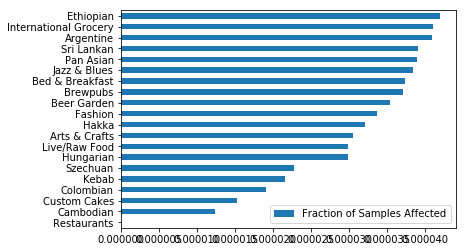

In [195]:
#feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf0.feature_importances_},
                           index=X.columns)
#feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')[:20]
#feat_scores.plot(kind='barh')

In [308]:
roc_auc_score(Y_train['cl_t0'], probs[:,1])

0.8526941057534566

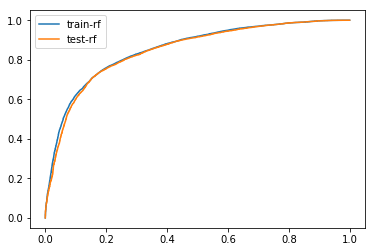

In [309]:
fig, ax = plt.subplots()
plot_roc_curve(Y_train['cl_t0'], X_train, rf0, ax,  'train-rf')
plot_roc_curve(Y_test['cl_t0'], X_test, rf0, ax,  'test-rf')
ax.legend()

In [310]:
gr0 = GradientBoostingClassifier( learning_rate=0.1, n_estimators=300,
                                  subsample=0.8,  
                                   max_depth=7,  random_state=179, max_features='sqrt')

In [311]:
%%time
gr0.fit(X_train, Y_train['cl_t0'])

CPU times: user 22.7 s, sys: 139 ms, total: 22.9 s
Wall time: 22.9 s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=179, subsample=0.8, verbose=0,
              warm_start=False)

In [227]:
%%time
cross_val_score(gr0,X_test,Y_test['cl_t0'],scoring= 'neg_log_loss')

CPU times: user 22.9 s, sys: 113 ms, total: 23 s
Wall time: 23 s


array([-0.60153555, -0.60666749, -0.61542372])

In [312]:
roc_auc_score(Y_train['cl_t0'], gr0.predict_proba(X_train)[:,1]), roc_auc_score(Y_test['cl_t0'], gr0.predict_proba(X_test)[:,1])

(0.9096924382208591, 0.8773976794606934)

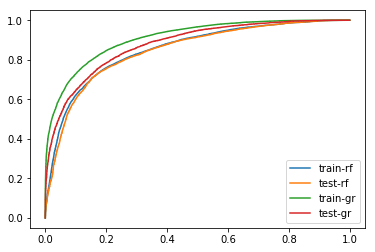

In [313]:
fig, ax = plt.subplots()
plot_roc_curve(Y_train['cl_t0'], X_train, rf0, ax,  'train-rf')
plot_roc_curve(Y_test['cl_t0'], X_test, rf0, ax,  'test-rf')
plot_roc_curve(Y_train['cl_t0'], X_train, gr0, ax,  'train-gr')
plot_roc_curve(Y_test['cl_t0'], X_test, gr0, ax,  'test-gr')

ax.legend()

## Gridsearch params for RF and GRBoosting

In [54]:
%%time
param_grid = {'max_depth' : [5,8, 12 ], 'max_features':[5,10,20,25] }
clust_model_rf ={}
for col in colClust_n:
    rf_c_grid =  GridSearchCV(RandomForestClassifier(n_estimators=400,  
                             min_samples_split=2, min_samples_leaf=1,   
                             max_leaf_nodes=None, bootstrap=True, n_jobs=-1, 
                             random_state=179,   class_weight=weights[col]),
                             param_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_log_loss')
    rf_c_grid.fit(X_train, Y_train[col])
    clust_model_rf[col] = rf_c_grid.best_estimator_
    #params = 
   # print("fot cluster ",col, " best parameters:", clust_model_rf[col].)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.3min finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.3min finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.3min finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.2min finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.4min finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.3min finished


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.3min finished


CPU times: user 5min, sys: 3.71 s, total: 5min 4s
Wall time: 9min 48s


In [55]:
%%time
#colClust
param_grid = {'max_depth' : [3,6,8 ], 'learning_rate':[0.05, 0.1] }
clust_model_gr ={}
for col in colClust_n:
    gr_c_grid = GridSearchCV(GradientBoostingClassifier( n_estimators=300,
                                  subsample=0.8,  
                                     random_state=179, max_features='sqrt'),
                             param_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_log_loss')
    gr_c_grid.fit(X_train, Y_train[col])
    clust_model_gr[col] = gr_c_grid.best_estimator_
    #print("fot cluster ",col, " best parameters:", gr_c_grid.best_params_)
    

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.2min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.0min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.0min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.1min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.1min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.0min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.1min finished


CPU times: user 2min 33s, sys: 1.93 s, total: 2min 35s
Wall time: 10min 7s


In [56]:
clust_model_rf.keys()

dict_keys(['cl_t0', 'cl_t1', 'cl_t3', 'cl_t4', 'cl_t5', 'cl_t8', 'cl_t9'])

# Оля ! сохрани модельки 

dict_keys(['cl_t0'])

In [ ]:
2+2

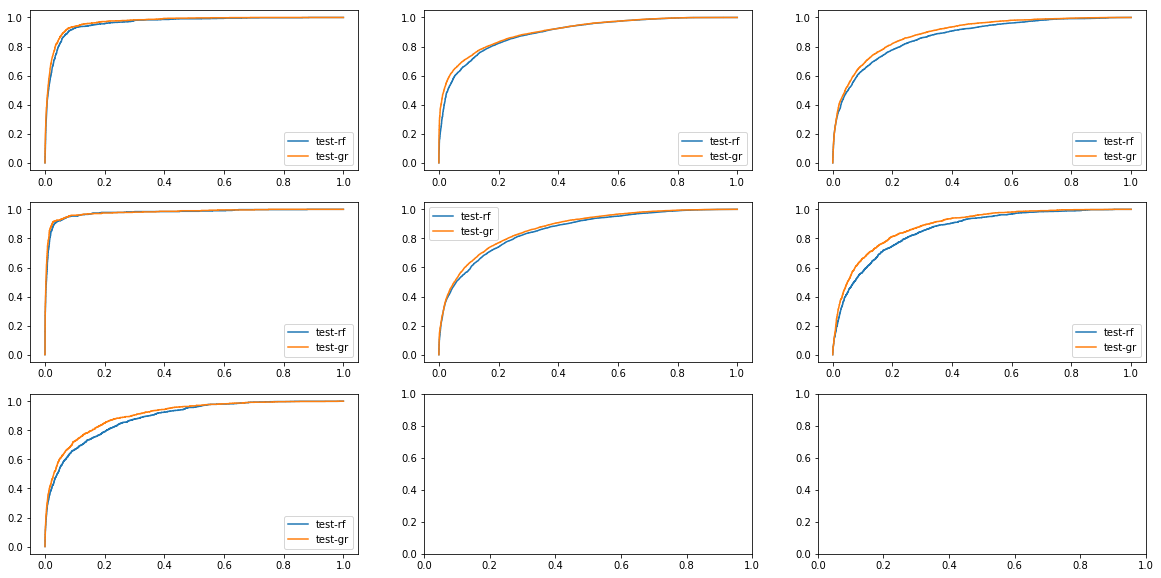

In [64]:
fig, axs = plt.subplots(3,3, figsize = (20,10))
for col, ax in zip(colClust_n, axs.flatten()):
    plot_roc_curve(Y_test[col], X_test, clust_model_rf[col], ax,  'test-rf')
    plot_roc_curve(Y_test[col], X_test, clust_model_gr[col], ax,  'test-gr')
    
    ax.legend()

In [58]:
for col in colClust_n:
    rf_auc = roc_auc_score(Y_test[col],  clust_model_rf[col].predict_proba(X_test)[:,1])
    print(col,'random forest ',rf_auc, '\n')
    gr_auc = roc_auc_score(Y_test[col],  clust_model_gr[col].predict_proba(X_test)[:,1])
    print(col,'gradient booster ',gr_auc, '\n')
    

cl_t0 random forest  0.9618491001591942 

cl_t0 gradient booster  0.9704478288244774 

cl_t1 random forest  0.8938306383615778 

cl_t1 gradient booster  0.9042941550338928 

cl_t3 random forest  0.8713422173135992 

cl_t3 gradient booster  0.892600541215206 

cl_t4 random forest  0.9766995763990536 

cl_t4 gradient booster  0.9794128401184425 

cl_t5 random forest  0.8568288264152107 

cl_t5 gradient booster  0.8707281741135398 

cl_t8 random forest  0.8592114217295561 

cl_t8 gradient booster  0.8870883355343806 

cl_t9 random forest  0.8872158665563024 

cl_t9 gradient booster  0.9069524711432272 



In [50]:
cw

cl_t0     0.451821
cl_t1     0.658139
cl_t2     0.111134
cl_t3     0.005717
cl_t4     0.203159
cl_t5     0.249445
cl_t7     0.059601
cl_t8     0.046809
cl_t9     0.037175
cl_t10    0.006788
cl_t11    0.052343
cl_t12    0.007858
cl_t13    0.029709
cl_t14    0.000731
cl_t16    0.053988
cl_t17    0.023887
dtype: float64

In [51]:
colOutliers = ['cl_t7', 'cl_t10', 'cl_t12', 'cl_t14', 'cl_t17']

In [59]:
clust_model_gr['cl_t4']

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=179, subsample=0.8, verbose=0,
              warm_start=False)

In [55]:
rf4 = RandomForestClassifier(bootstrap=True, class_weight={1: 0.2, 0: 0.8},
            criterion='gini', max_depth=7, max_features=25,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False, random_state=179,
            verbose=0, warm_start=False)


In [60]:
gr4 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=179, subsample=0.8, verbose=0,
              warm_start=False)

In [56]:
cross_val_score(rf4, X_train,Y_train['cl_t4'],scoring= 'neg_log_loss')

array([-0.44293941, -0.44327626, -0.44027319])

In [61]:
cross_val_score(gr4, X_train,Y_train['cl_t4'],scoring= 'neg_log_loss')

array([-0.30677927, -0.30311866, -0.30227886])

In [64]:
gr4.fit(X_train,Y_train['cl_t4'])
rf4.fit(X_train,Y_train['cl_t4'])

RandomForestClassifier(bootstrap=True, class_weight={1: 0.2, 0: 0.8},
            criterion='gini', max_depth=7, max_features=25,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=-1, oob_score=False, random_state=179,
            verbose=0, warm_start=False)

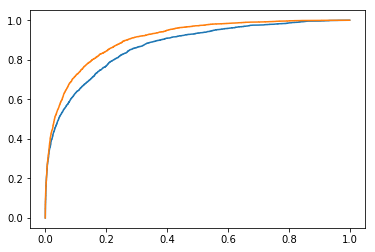

In [65]:

fig, ax = plt.subplots()
plot_roc_curve(Y_test['cl_t4'], X_test, rf4, ax,  'test-rf')
plot_roc_curve(Y_test['cl_t4'], X_test, gr4, ax,  'test-gr')
   

In [ ]:
clust_model_gr['cl_t4'] = gr4
clust_model_rf['cl_t4'] = rf4


In [76]:
for col in colOutliers:

    clust_model_gr[col] = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=179, subsample=0.8, verbose=0,
              warm_start=False)
    clust_model_gr[col].fit(X_train,Y_train[col])
    clust_model_rf[col] = RandomForestClassifier(n_estimators=400, max_depth=7, max_features=25, 
                             min_samples_split=2, min_samples_leaf=1,   
                             max_leaf_nodes=None, bootstrap=True, n_jobs=-1, 
                             random_state=179,   class_weight=weights[col])
    clust_model_rf[col].fit(X_train,Y_train[col])



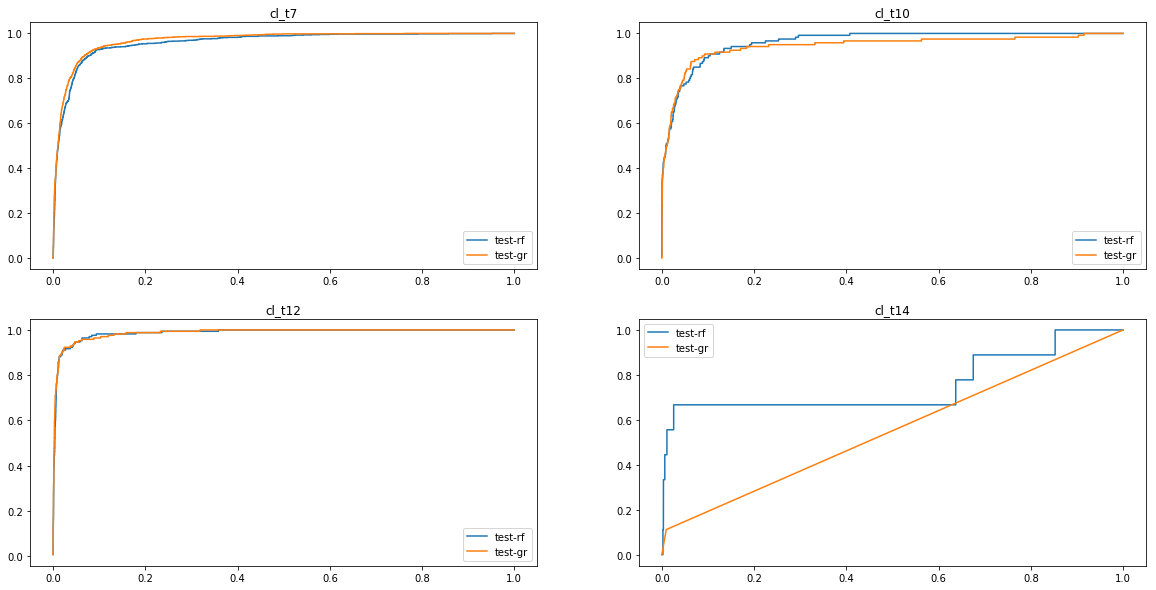

In [77]:
fig, axs = plt.subplots(2,2, figsize = (20,10))
for col, ax in zip(colOutliers, axs.flatten()):
    plot_roc_curve(Y_test[col], X_test, clust_model_rf[col], ax,  'test-rf')
    plot_roc_curve(Y_test[col], X_test, clust_model_gr[col], ax,  'test-gr')
    ax.set_title(col)
    ax.legend()

In [60]:
for col in colClust_n:
    filename_gr = 'gr10boost/mgr_'+col+'.pkl'
    with open(filename_gr, 'wb') as f:
        pickle.dump(clust_model_gr[col], f)
    filename_rf = 'r10forest/mrf_'+col+'.pkl'
    with open(filename_rf, 'wb') as f:
        pickle.dump(clust_model_rf[col], f)
    

## unpickle, looking for threshold

In [67]:
clust_model_gr = {}
clust_model_rf = {}
for col in colClust_n:
    filename_gr = 'grboost/mgr_'+col+'.pkl'
    with open(filename_gr,'rb') as f:
        clust_model_gr[col]= pickle.load( f)
    filename_rf = 'rforest/mrf_'+col+'.pkl'
    with open(filename_rf,'rb') as f:
        clust_model_rf[col] =pickle.load( f)

In [61]:
def calc_thres(y_true, X, model,  thres = 0.7,label = ''):
    """Plot roc curve, y_true & model.predict_proba(X), ax --- axes of subplot"""
    fpr, tpr, thr = roc_curve(y_true, model.predict_proba(X)[:,1])
    idx = np.abs(tpr - thres).argmin()
    print(label, ':  ', col,' ', tpr[idx], ' ', fpr[idx], ' ', thr[idx])
    return thr[idx]

In [62]:

for col in colClust_n:
    calc_thres(Y_test[col], X_test, clust_model_rf[col], 0.7,  'test-rf')
    calc_thres(Y_test[col], X_test, clust_model_gr[col], 0.7,  'test-gr')
    

test-rf :   cl_t0   0.6998175182481752   0.02942831420211569   0.07342477801510229
test-gr :   cl_t0   0.7007299270072993   0.021663290569435067   0.40925117649584686
test-rf :   cl_t1   0.699961285327139   0.10666890643373089   0.8743882482046607
test-gr :   cl_t1   0.700116144018583   0.08113556190156224   0.818782474971365
test-rf :   cl_t3   0.7000903342366757   0.13777577667717245   0.07046806802661014
test-gr :   cl_t3   0.7003914483589281   0.11153277159580627   0.27174059908992876
test-rf :   cl_t4   0.7001934235976789   0.010408152144297314   0.1022372216341514
test-gr :   cl_t4   0.6982591876208898   0.007302054383957278   0.4239287543479013
test-rf :   cl_t5   0.6998689384010485   0.16285946625267983   0.17597570655907435
test-gr :   cl_t5   0.7000561692566935   0.14341686996377614   0.3758835508767579
test-rf :   cl_t8   0.7004608294930875   0.1607081862689286   0.014617787422720357
test-gr :   cl_t8   0.6996927803379416   0.11949220084253671   0.1112196538843945
test-rf : 

In [63]:
th_gr72 ={}
th_rf72 = {}
for col in colClust_n:
    th_rf72[col] = max(calc_thres(Y_test[col], X_test, clust_model_rf[col], 0.72,  'test-rf'), 0.01)
    th_gr72[col] = max(calc_thres(Y_test[col], X_test, clust_model_gr[col], 0.72,  'test-gr'),0.01)


test-rf :   cl_t0   0.7208029197080292   0.03291694800810263   0.06769838557231074
test-gr :   cl_t0   0.7198905109489051   0.02357641233400855   0.38653860390291483
test-rf :   cl_t1   0.7199380565234224   0.11540399798420964   0.8652908575099767
test-gr :   cl_t1   0.7199380565234224   0.09575004199563246   0.7977294284623546
test-rf :   cl_t3   0.7199638663053297   0.15244098539911236   0.06617415180844217
test-gr :   cl_t3   0.7199638663053297   0.12272464140991832   0.2542358388971034
test-rf :   cl_t4   0.7214700193423598   0.011116560405427496   0.09585348969097034
test-gr :   cl_t4   0.7195357833655706   0.00801046264508746   0.3851789658693065
test-rf :   cl_t5   0.7202771016663546   0.17882753012493532   0.16827459820472587
test-gr :   cl_t5   0.7200898708107096   0.1579803356250462   0.35004048196828397
test-rf :   cl_t8   0.7196620583717358   0.16987361949220084   0.013878379384350532
test-gr :   cl_t8   0.7196620583717358   0.13520437208243197   0.09864722810345845
test-rf

In [66]:
with open('thres_1072_gr', 'wb') as f:
    pickle.dump(th_gr72,f)
with open('thres_1072_rf','wb') as f:
    pickle.dump(th_rf72,f )

In [65]:
th_gr35 ={}
th_rf35 = {}
for col in colClust_n:
    th_rf35[col] = max(calc_thres(Y_test[col], X_test, clust_model_rf[col], 0.35,  'test-rf'), 0.01)
    th_gr35[col] = max(calc_thres(Y_test[col], X_test, clust_model_gr[col], 0.35,  'test-gr'),0.01)
with open('thres_1035_gr', 'wb') as f:
    pickle.dump(th_gr35,f)
with open('thres_1035_rf','wb') as f:
    pickle.dump(th_rf35,f )

test-rf :   cl_t0   0.3494525547445255   0.005626828719333784   0.21094267618277315
test-gr :   cl_t0   0.34854014598540145   0.0038825118163403104   0.7640737618884302
test-rf :   cl_t1   0.35067750677506776   0.013606584915168822   0.9380036389449167
test-gr :   cl_t1   0.3500580720092915   0.004199563245422476   0.9699679028714339
test-rf :   cl_t3   0.3498946100572117   0.01852447417508201   0.2376970897613922
test-gr :   cl_t3   0.3498946100572117   0.015694346176111148   0.658621575896516
test-rf :   cl_t4   0.35009671179883944   0.0016892812380796688   0.3514160481934994
test-gr :   cl_t4   0.35009671179883944   0.0011443518064410659   0.8080660528375904
test-rf :   cl_t5   0.34974723834487925   0.02055148961336586   0.45003694941409067
test-gr :   cl_t5   0.35030893091181425   0.019812227397057736   0.7534783418257361
test-rf :   cl_t8   0.3486943164362519   0.03330297164977798   0.06039388424350256
test-gr :   cl_t8   0.35023041474654376   0.02311283160651258   0.3702875580558